<h1 align="center">Abalone age prediction</h1>

# What is Abalone?
<p style="font-size: 18px">Abalone is a popular choice of seafood—a shellfish to be precise—that lives in cold coastal waters around the world. Biologically, abalone is a mollusk belonging to the Gastropoda class. In plain English, this means that abalone is technically <b>a type of marine snail</b>.</p>

<img src="https://i2.wp.com/www.tastyislandhawaii.com/images10/kccfm/kona_abalone_pregrill.jpg" width="600px">

# How to determine the age of an abalone?
<p style="font-size: 18px">Scientific studies on abalones require knowing the age of an abalone, but the process of determining age is complicated. It involves measuring the number of layers of shell (“rings”) that make up the abalone’s shell. This is done by taking a sample of shell, staining it and counting the number of rings under the microscope.<b>This process is tedious and time-consuming.</b></p>

# How machine learning can solve this problem?
<p style="font-size: 18px">As we know, Age is a number and we have data that contains the physical measurements of abalones and their ages. We can build a machine learning model that can predict the age of abalone given its physical measurements like weight, height, etc.</p>

---

<b style="font-size: 20px; color: green"> About the data set</b>
<p style="font-size: 18px">
    Data comes from an original (non-machine-learning) study : The Population Biology of Abalone (_Haliotis_ species) in Tasmania.<br>
    From the original data examples with missing values were removed, and the ranges of the continuous values have been scaled by dividing with 200.
</p>

## Variable discription
<p style="font-size: 18px">
<b>`Sex`:</b> M (male), F (female), I (infant)<br>
<b>`Length`:</b> longest shell measurement (in mm)<br>
<b>`Diameter`:</b> measurement perpendicular to legnth (in mm)<br>
<b>`Height`:</b> with meat in shell (in mm)<br>
<b>`Whole weight`:</b> the whole abalone (in grams)<br>
<b>`Shucked weight`:</b> weight of the meat (in grams)<br>
<b>`Viscera weight`:</b> gut weight after bleeding (in grams)<br>
<b>`Shell weight`:</b> after being dried (in grams)<br>
<b>`Rings`:</b> + 1.5 gives the age in years (the value to predict)
 </p>
 
 ---

# Table of contents

- [Exploratory data analysis](#2)

- [Modeling](#3)
    
    - [Feature Engineering](#3.0)

    - [Initial Modeling](#3.1) 
    
    - [Hyperparameter tuning](#3.2)
    
    - [Final Modeling](#3.3)
    
- [Evaluation](#4)

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
sns.set()

# ----------------------- Helper functions -------------------

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_model(model, X_train, y_train, X_test, y_test):
    _ = model.fit(X_train, y_train)
    print("Train rmse : ", rmse(y_train, model.predict(X_train)))
    print("Test rmse : ", rmse(y_test, model.predict(X_test)))

## Read the data

In [2]:
data = pd.read_csv('/kaggle/input/abalone-dataset/abalone.csv')

# add target(age) to dataset [rings + 1.5 = age ]
data['age'] = data.Rings + 1.5

 # remove rings variable
data.drop('Rings', axis=1, inplace=True)

print("Data loaded Successfully!")

Data loaded Successfully!


<a id=2></a>
<h1 style="color: green;">2. Exploratory data analysis</h1>
<p style="font-size: 20px">Exploratory Data Analysis or EDA is very crucial for the success of all data science projects. It is an approach to analyze and understand the various aspects of the data.
</p>
<img src="https://static.wixstatic.com/media/704a47_602aa053d04d4d54a4a8aaf75fbfea01~mv2.png/v1/fill/w_740,h_335,al_c,q_90/704a47_602aa053d04d4d54a4a8aaf75fbfea01~mv2.webp" width="700px">

### Data Sample

In [3]:
data.sample(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,age
4103,M,0.700,0.545,0.215,1.9125,0.8825,0.4385,0.506,11.5
1343,M,0.585,0.460,0.165,1.1135,0.5825,0.2345,0.274,11.5
1771,I,0.455,0.325,0.135,0.8200,0.4005,0.1715,0.211,9.5
2871,I,0.375,0.280,0.085,0.2145,0.0855,0.0485,0.072,8.5
1623,F,0.565,0.440,0.150,0.8630,0.4350,0.1490,0.270,10.5


### Dimensions

In [4]:
print("No. of rows : ", data.shape[0])
print("No. of columns : ", data.shape[1])

No. of rows :  4177
No. of columns :  9


### Statistical summary of features

In [5]:
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,11.433684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,2.500000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,9.500000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,10.500000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,12.500000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,30.500000


### Missing values

In [6]:
data.isna().mean().to_frame(name='% of missing values') # No missing values

,% of missing values
Sex,0.0
Length,0.0
Diameter,0.0
Height,0.0
Whole weight,0.0
Shucked weight,0.0
Viscera weight,0.0
Shell weight,0.0
age,0.0


### Unique values

In [7]:
data.nunique().to_frame("# of unique values")

,# of unique values
Sex,3
Length,134
Diameter,111
Height,51
Whole weight,2429
Shucked weight,1515
Viscera weight,880
Shell weight,926
age,28


# Train test split
<p style="font-size: 20px">Train test split is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.The motivation is quite simple: you should separate your data into train and test splits to prevent your model from overfitting and to accurately evaluate your model.<b> It is also a good practice to only use train data to perform further analysis.</b><br><br>
    <b>Train :</b> 75% of data<br>
    <b>Test :</b> 25% of data<br>
</p>

In [8]:
# train test split

train, test = train_test_split(data, test_size=0.25, random_state=1)
print('Train data points :', len(train))
print('Test data points :', len(test))

Train data points : 3132
Test data points : 1045


## Variable separation

In [9]:
numerical_features = ["Length", 'Diameter', 'Height','Whole weight',
                      'Shucked weight', 'Viscera weight', 'Shell weight']

categorical_feature = "Sex"

features = numerical_features + [categorical_feature]

target = 'age'

## Target distribution

In [1]:
fig, axes = plt.subplots(ncols=2,figsize=(16, 5))

train[target].plot.hist(color='blue', ax=axes[0])
axes[0].set(title="Train")

test[target].plot.hist(color='blue', ax=axes[1])
axes[1].set(title="Test")

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## Distribution of numerical features

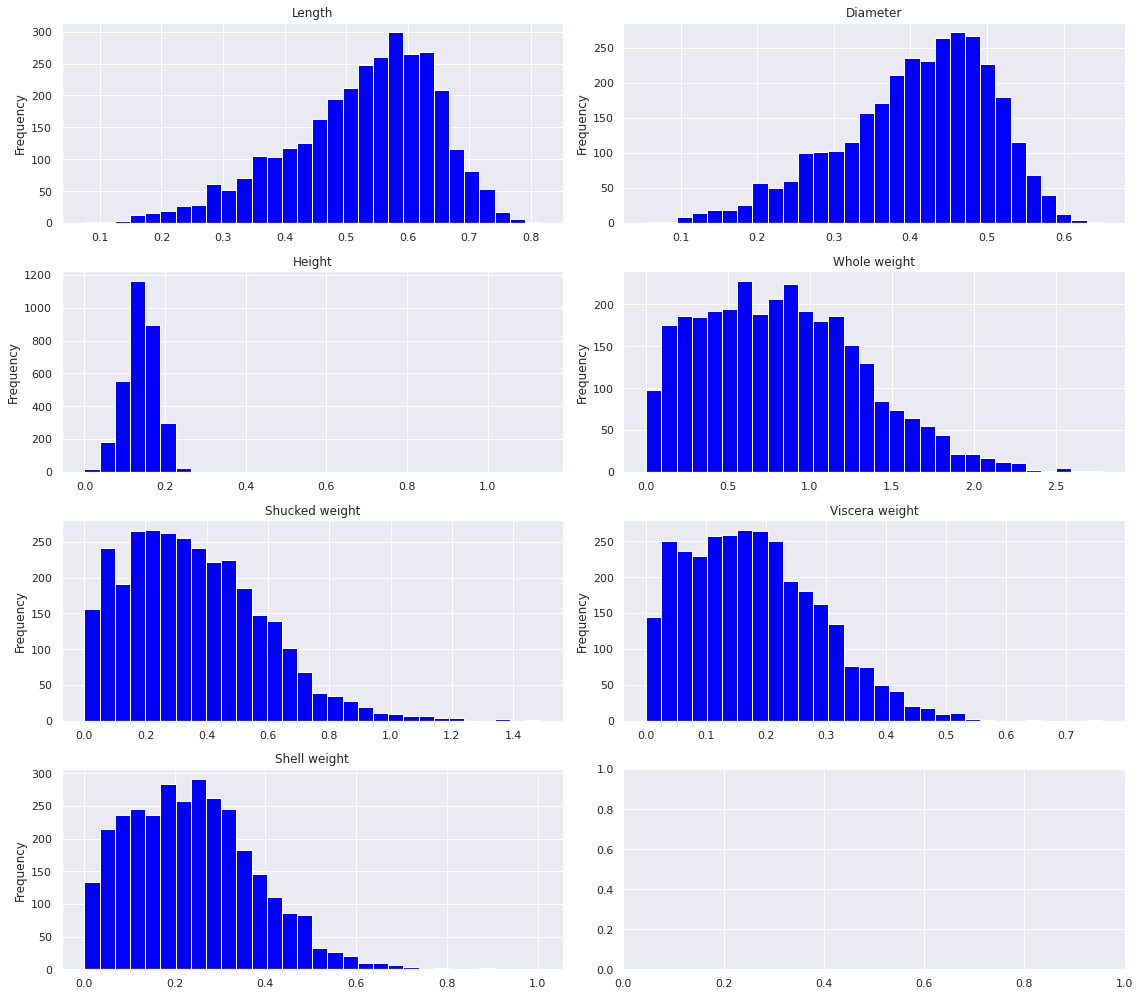

In [11]:
fig, axes = plt.subplots(4,2,figsize=(16, 14))
axes = np.ravel(axes)

for i, c in enumerate(numerical_features):
    hist = train[c].plot(kind = 'hist', ax=axes[i], title=c, color='blue', bins=30)
    
plt.tight_layout()
plt.show()

### Box plot (Outliers)
<p style="font-size: 18px">Outliers are data points that are far from other data points. In other words, they’re unusual values in a dataset.</p>

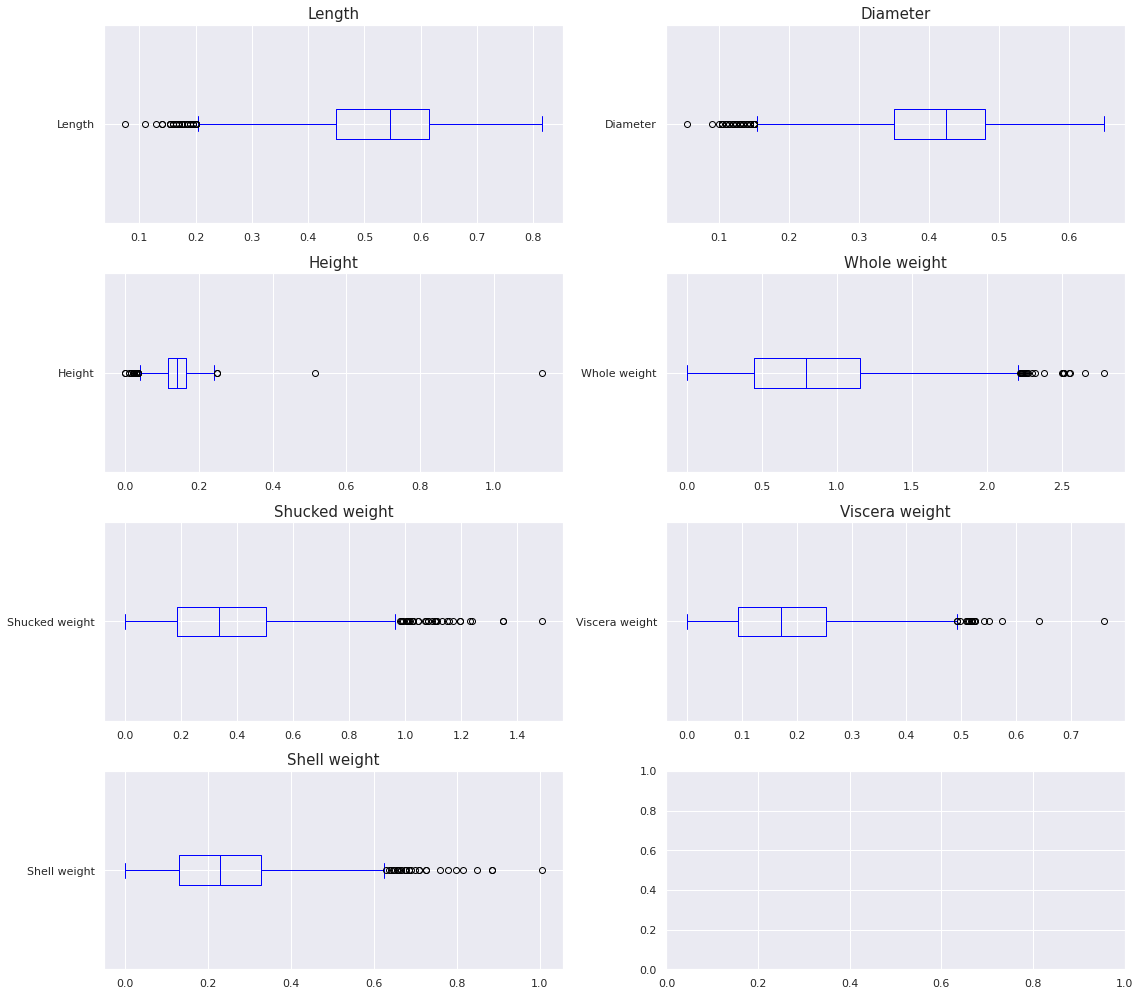

In [12]:
fig, axes = plt.subplots(4,2,figsize=(16, 14))
axes = np.ravel(axes)

for i, c in enumerate(numerical_features):
    hist = train[c].plot(kind = 'box', ax=axes[i],color='blue', vert=False)
    axes[i].set_title(c, fontsize=15)
    
plt.tight_layout()
plt.show()

<p style="font-size: 18px">Observation : <br>Most of our features contain outliers.<br> 'Height' feature as extreme outliers.</p>

### Pie chart : Categorical feature `sex`

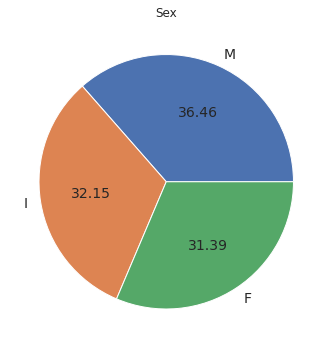

In [13]:
t = train[categorical_feature].value_counts(normalize=True)
t.plot(kind='pie',
       figsize=(5,5),
       title=categorical_feature,
       ylabel="",
       autopct="%.2f",
       fontsize=14)
plt.tight_layout()
plt.show()

## Pearson Correlation

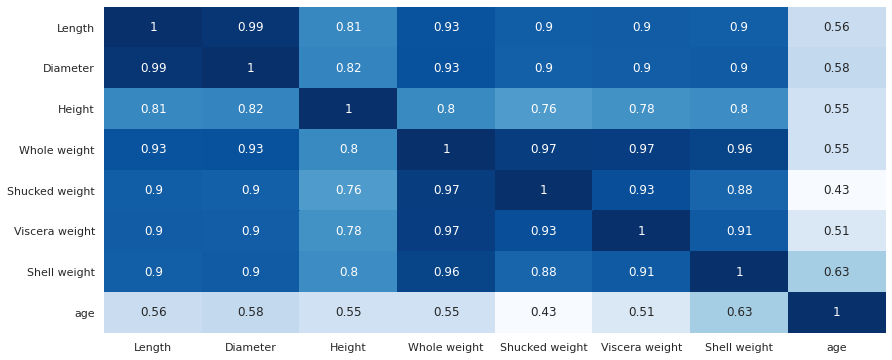

In [14]:
plt.figure(figsize=(14,6))
sns.heatmap(train.corr(method='pearson'),
            annot=True,
            cbar=False,
            cmap='Blues')
plt.show()

### Scatter plot
#### Relation with target column

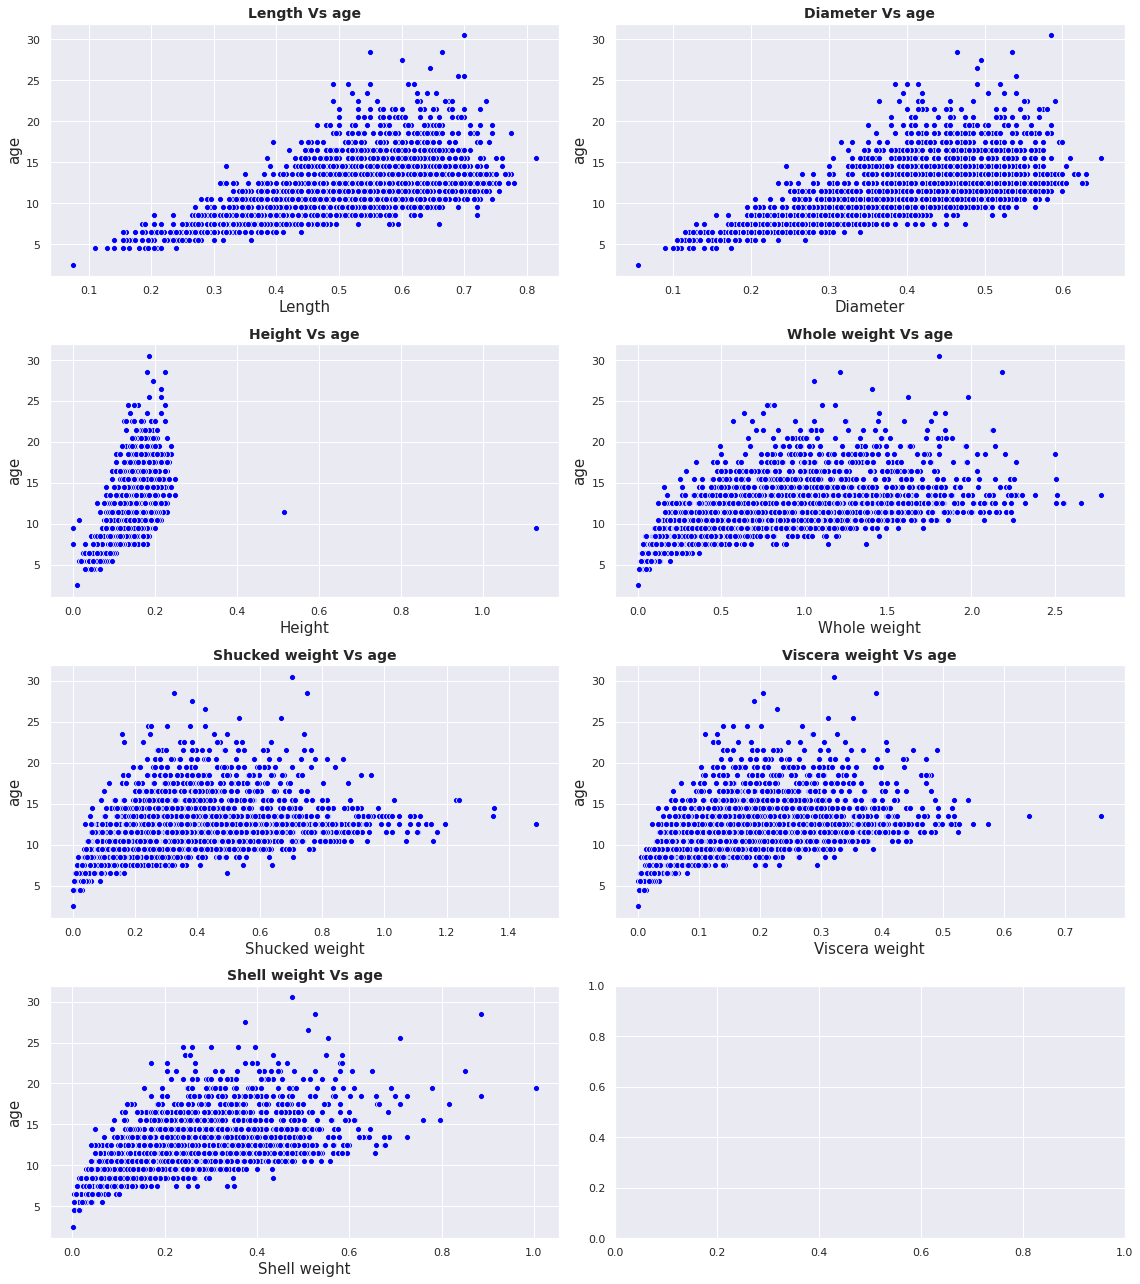

In [15]:
fig, axes = plt.subplots(4,2,figsize=(16, 18))
axes = np.ravel(axes)

for i, c in enumerate(numerical_features):
    _ = sns.scatterplot(x=train[c],
                        y=train[target],
                        ax=axes[i],
                        color='blue')
    
    axes[i].set_title(f"{c} Vs age",
                      fontsize=14, 
                      fontweight='bold')
    
    axes[i].set_xlabel(c, fontsize=15)
    axes[i].set_ylabel('age', fontsize=15)
    
plt.tight_layout()
plt.show()

<p style="font-size: 18px">Observation : Some features has a linear relationship with target.</p>

### Height Vs Length Vs age

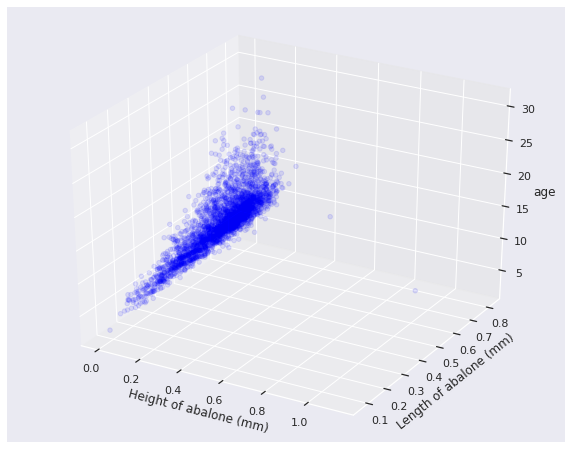

In [16]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

ax.set_xlabel('Height of abalone (mm)')
ax.set_ylabel('Length of abalone (mm)')
ax.set_zlabel('age')
ax.scatter3D(train['Height'],
             train['Length'], 
             train[target],
             c='blue',
             alpha=0.1);

plt.show()

<a id=3></a>
<h1 style="font-size: 25px; color:green">3. Modeling</h1>

<a id="3.0"></a>
<h2>3.1 Feature Engineering</h2>
<p style="font-size: 18px">Feature engineering is the general term for the process of creating and manipulating features, so that a good predictive model can be created.</p>

### Label encoding

In [17]:
train.Sex = train.Sex.replace({"M":1, "I":0, "F":-1})
test.Sex = test.Sex.replace({"M":1, "I":0, "F":-1})

### Removing outliers

In [18]:
idx = train.loc[train.Height>0.4].index
train.drop(idx, inplace=True)

idx = train.loc[train['Viscera weight']>0.6].index
train.drop(idx, inplace=True)

idx = train.loc[train[target]>25].index
train.drop(idx, inplace=True)

### Feature separation

In [19]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex
4014,0.625,0.480,0.175,1.0650,0.4865,0.2590,0.285,1
3252,0.480,0.380,0.130,0.6175,0.3000,0.1420,0.175,1
305,0.200,0.145,0.060,0.0370,0.0125,0.0095,0.011,0
1857,0.505,0.400,0.145,0.7045,0.3340,0.1425,0.207,0
439,0.500,0.415,0.165,0.6885,0.2490,0.1380,0.250,1


<a id="3.1"></a>
<h2>3.2 Initial Modeling</h2>
<p style="font-size: 18px"> Since it is a regression problem we can use the <b>Root mean squared error</b> as the performance metric.
    <img src="https://www.datascienceland.com/media/uploads/2020/12/15/rmse">
</p>

### Base models

In [20]:
models = {'linear_regression':LinearRegression(),
         
         'lasso':Lasso(random_state=1),
         
         'decision_tree':DecisionTreeRegressor(random_state=1),
         
         'random_forest':RandomForestRegressor(random_state=1),
         
         'xgboost':XGBRegressor(random_state=1),
        }

In [21]:
# 
for key, regressor in models.items():
    print(key)
    eval_model(regressor, X_train, y_train, X_test, y_test)
    print("\n------------------------------------------")

linear_regression
Train rmse :  2.1601637766834694
Test rmse :  2.1993326495103673

------------------------------------------
lasso
Train rmse :  3.1425445775484584
Test rmse :  3.2071190143034873

------------------------------------------
decision_tree
Train rmse :  0.0
Test rmse :  2.8672378052018894

------------------------------------------
random_forest
Train rmse :  0.7983734867135102
Test rmse :  2.1456051220373515

------------------------------------------
xgboost
Train rmse :  0.7048710489942694
Test rmse :  2.2560493392094654

------------------------------------------


<a id="3.2"></a>
## 3.3 Hyperparameter tuning

In [22]:
# Linear regression
lr_params = {'fit_intercept':[True,False]}

# Lasso
lasso_params = {'alpha': [1e-4, 1e-3, 1e-2, 1, 10, 100]}

# Decision tree
dt_params =  {'max_depth': [4, 6, 8, 10, 12, 14, 16, 20],
            'min_samples_split': [5, 10, 20, 30, 40, 50],
            'max_features': [0.2, 0.4, 0.6, 0.8, 1],
            'max_leaf_nodes': [8, 16, 32, 64, 128,256]}

# Random Forest
rf_params = {'bootstrap': [True, False],
             'max_depth': [2, 5, 10, 20, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [100, 150, 200, 250]}

# XGBoost
xgb_params = {'n_estimators':[100, 200, 300] , 
             'max_depth':list(range(1,10)) , 
             'learning_rate':[0.006,0.007,0.008,0.05,0.09] ,
             'min_child_weight':list(range(1,10))}

In [23]:
params = [lr_params, lasso_params, dt_params, rf_params, xgb_params]

# searching Hyperparameters
i=0
for name, model in models.items():
    print(name)
    regressor = RandomizedSearchCV(estimator = model,
                                   n_iter=10,
                                   param_distributions = params[i],
                                   cv = 3,
                                   scoring = 'neg_root_mean_squared_error')
    
    search = regressor.fit(X_train, y_train)
    
    print('Best params :',search.best_params_)
    print("RMSE :", -search.best_score_)
    i+=1
    print()

linear_regression
Best params : {'fit_intercept': True}
RMSE : 2.1685158384088488

lasso
Best params : {'alpha': 0.0001}
RMSE : 2.168463202118033

decision_tree
Best params : {'min_samples_split': 30, 'max_leaf_nodes': 128, 'max_features': 0.8, 'max_depth': 4}
RMSE : 2.353825847345721

random_forest
Best params : {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
RMSE : 2.1178634532371317

xgboost
Best params : {'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05}
RMSE : 2.1439799354381552



<a id="3.3"></a>
## 3.4 Final Modeling
### Random forest is performing better : Selected

In [24]:
rf_params = {'n_estimators': 200, 
             'min_samples_split': 2,
             'min_samples_leaf': 4, 
             'max_features': 'sqrt', 
             'max_depth': None, 
             'bootstrap': True}

model = RandomForestRegressor(random_state=1, **rf_params)

model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4, n_estimators=200,
                      random_state=1)

### Save the model
<p style="font-size: 18px">Saving model for deployment step..</p>

In [25]:
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

<h1 style="color:green;">Evaluation</h1>

In [26]:
print("Train rmse : ", rmse(y_train, model.predict(X_train)))
print("Test rmse : ", rmse(y_test, model.predict(X_test)))

Train rmse :  1.5313840467501842
Test rmse :  2.146490954202156


### Feature importance

In [27]:
df = pd.DataFrame([features, model.feature_importances_]).T
df.columns = ['feature', 'importance']
df.sort_values("importance", ascending=False)

,feature,importance
6,Shell weight,0.247956
3,Whole weight,0.157105
2,Height,0.135278
5,Viscera weight,0.124763
4,Shucked weight,0.1204
1,Diameter,0.109247
0,Length,0.0805097
7,Sex,0.0247428


## Scatter plot

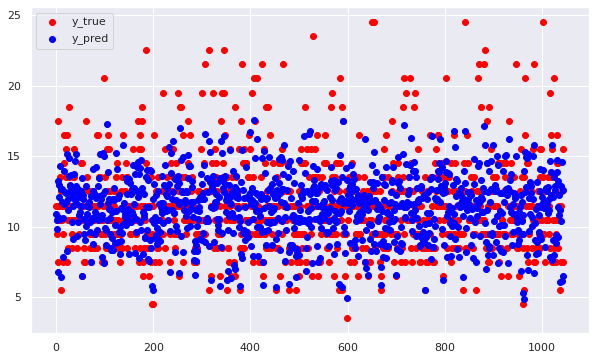

In [28]:
y_pred = model.predict(X_test)

fig = plt.figure(figsize=(10, 6))
plt.scatter(range(y_test.shape[0]), y_test, color='red', label='y_true')
plt.scatter(range(y_test.shape[0]), y_pred, color='blue', label='y_pred')
plt.legend()
plt.show()

## Error distribution

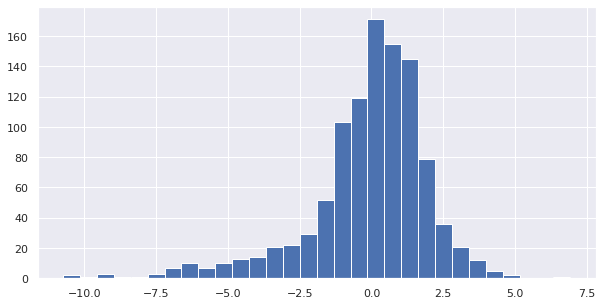

In [29]:
plt.figure(figsize=(10,5))
plt.hist(y_pred-y_test, bins=30)
plt.show()

### Prediction on single data point

In [30]:
def predict_age(x):
    x = pd.DataFrame([x], columns=features)
    age = model.predict(x)
    return round(age[0],2)

In [31]:
with open("model.pkl", 'rb') as f:
    model = pickle.load(f)
    
# Random sample from test set
ex = [0.295 , 0.225 , 0.08  , 0.124 , 0.0485, 0.032 , 0.04  , 0.]

print("Estimated age : ",predict_age(ex))

Estimated age :  8.86


In [32]:
## Thank you..!! ##